In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
import keras

from pathlib import Path

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15, 8)

In [26]:
df = pd.read_csv(
    "../data/Air Temperature Fix.csv", index_col='datetime', parse_dates=True
)
df

,airTemperature
datetime,
2024-11-01 10:21:00+00:00,26.55
2024-11-01 10:22:00+00:00,26.60
2024-11-01 10:23:00+00:00,26.60
2024-11-01 10:24:00+00:00,26.65
2024-11-01 10:25:00+00:00,26.70
...,...
2024-11-24 12:23:00+00:00,27.81
2024-11-24 12:24:00+00:00,27.80
2024-11-24 12:25:00+00:00,27.80


In [27]:
df = df.asfreq("1min")
df

,airTemperature
datetime,
2024-11-01 10:21:00+00:00,26.55
2024-11-01 10:22:00+00:00,26.60
2024-11-01 10:23:00+00:00,26.60
2024-11-01 10:24:00+00:00,26.65
2024-11-01 10:25:00+00:00,26.70
...,...
2024-11-24 12:23:00+00:00,27.81
2024-11-24 12:24:00+00:00,27.80
2024-11-24 12:25:00+00:00,27.80


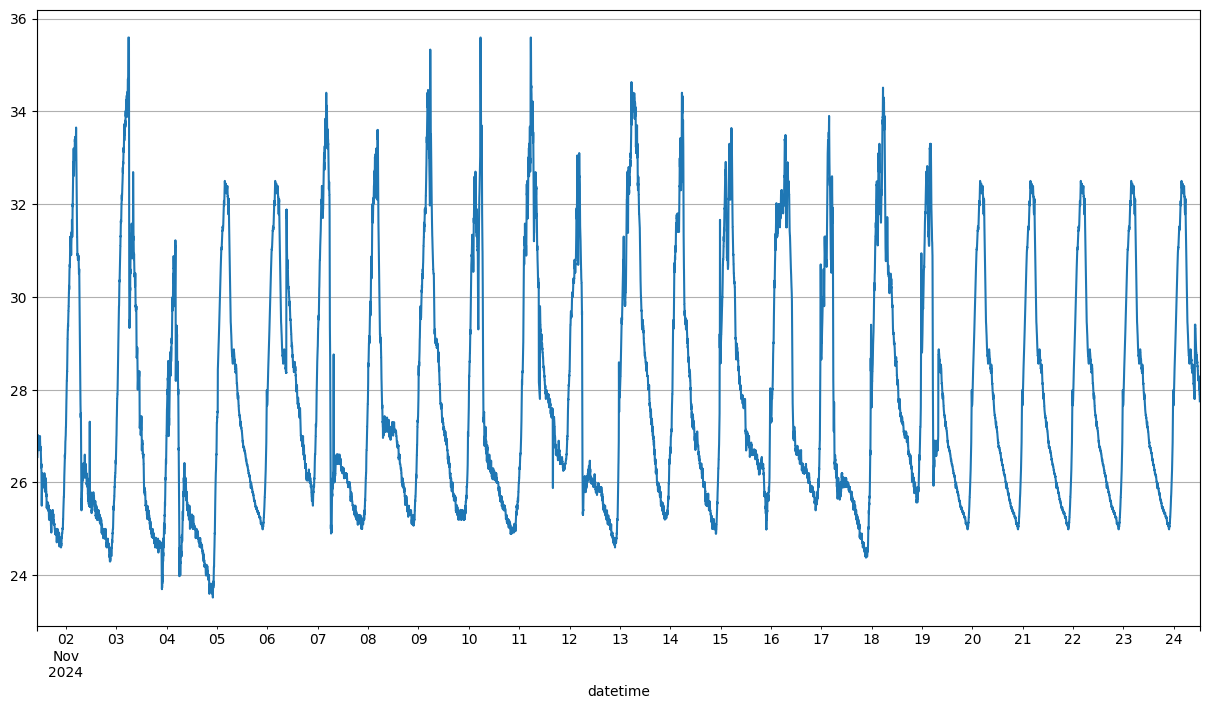

In [28]:
fig, ax = plt.subplots()
df["airTemperature"].plot(ax=ax)
plt.grid()
plt.show()

In [29]:
print(f"Number data NaN\t: {df.isna().sum()}")

Number data NaN	: airTemperature    0
dtype: int64


In [30]:
train, test = (
    df.iloc[: int(np.round(df.shape[0] * 0.7))],
    df.iloc[int(np.round(df.shape[0] * 0.7)) :],
)
train.shape, test.shape

((23273, 1), (9974, 1))

In [31]:
scaler = StandardScaler()
scaler.fit(df)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
train_scaled.shape, test.shape

((23273, 1), (9974, 1))

In [32]:
def create_features(dataset, n_past=60, n_future=1):
    X, y = list(), list()

    for i in range(n_past, len(dataset) - n_future + 1):
        X.append(dataset[i - n_past : i, 0 : dataset.shape[1]])
        y.append(dataset[i + n_future - 1 : i + n_future, 0])

    return np.array(X), np.array(y)


X_train, y_train = create_features(train_scaled, n_past=1)
X_test, y_test = create_features(test_scaled, n_past=1)

In [33]:
print(f"X_train shape\t: {X_train.shape}")
print(f"y_train shape\t: {y_train.shape}")

X_train shape	: (23272, 1, 1)
y_train shape	: (23272, 1)


In [34]:
model = keras.Sequential(name="LSTM")
model.add(keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(
    keras.layers.LSTM(
        64, activation=keras.activations.relu, return_sequences=True, name="lstm_1"
    )
)
model.add(
    keras.layers.LSTM(
        32, activation=keras.activations.relu, return_sequences=False, name="lstm_2"
    )
)
model.add(keras.layers.Dropout(0.2, name="dropout"))
model.add(keras.layers.Dense(y_train.shape[1], name="dense"))

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.RootMeanSquaredError(),
    ],
)

In [35]:
model.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode="auto", baseline=None, restore_best_weights=False, start_from_epoch=50)

In [37]:
history = model.fit(
    X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, verbose=1, callbacks=[earlyStopping]
)

Epoch 1/500
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4246 - mean_absolute_error: 0.4246 - mean_absolute_percentage_error: 76.7587 - root_mean_squared_error: 0.6166 - val_loss: 0.0559 - val_mean_absolute_error: 0.0559 - val_mean_absolute_percentage_error: 23.0549 - val_root_mean_squared_error: 0.0881
Epoch 2/500
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1164 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 32.2276 - root_mean_squared_error: 0.1780 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265 - val_mean_absolute_percentage_error: 40.5757 - val_root_mean_squared_error: 0.0338
Epoch 3/500
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1133 - mean_absolute_error: 0.1133 - mean_absolute_percentage_error: 26.6487 - root_mean_squared_error: 0.1759 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276 - val_mean_absolute_percentage_error: 17.8277 - val_root_mean_squared_error: 0.0427
Epoch 4/500
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1093

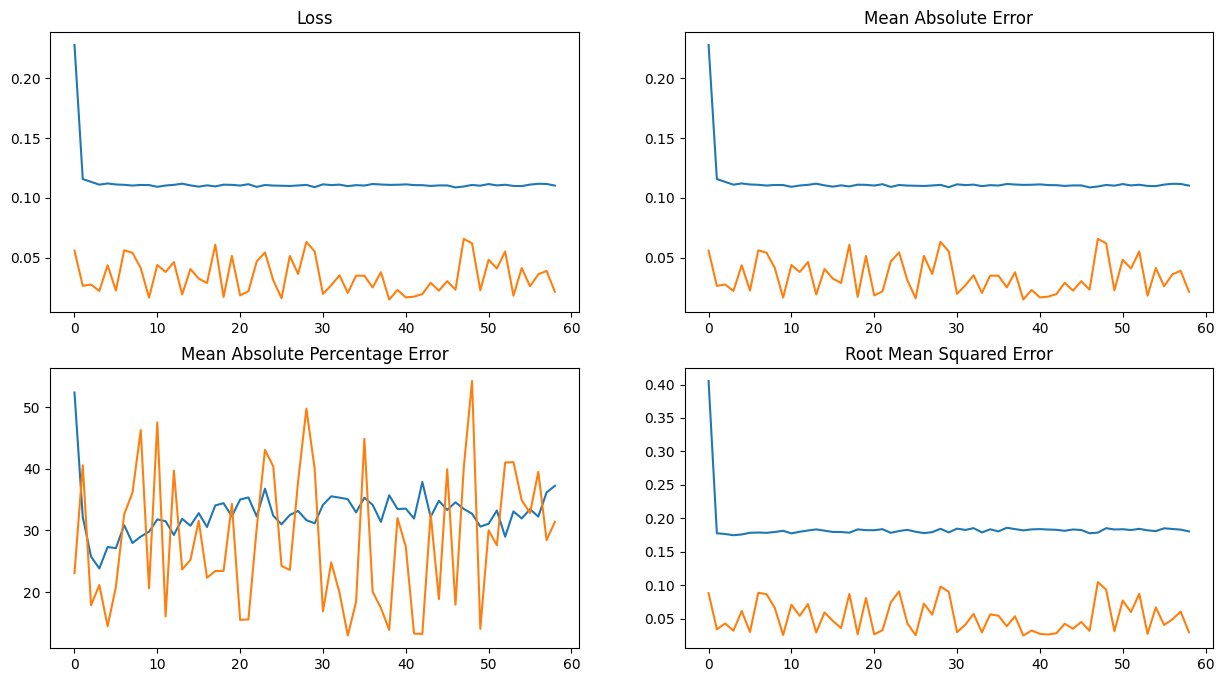

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0][0].plot(history.history['loss'])
ax[0][0].plot(history.history['val_loss'])
ax[0][0].set_title('Loss')
ax[0][1].plot(history.history['mean_absolute_error'])
ax[0][1].plot(history.history['val_mean_absolute_error'])
ax[0][1].set_title('Mean Absolute Error')
ax[1][0].plot(history.history['mean_absolute_percentage_error'])
ax[1][0].plot(history.history['val_mean_absolute_percentage_error'])
ax[1][0].set_title('Mean Absolute Percentage Error')
ax[1][1].plot(history.history['root_mean_squared_error'])
ax[1][1].plot(history.history['val_root_mean_squared_error'])
ax[1][1].set_title('Root Mean Squared Error')
plt.show()

In [39]:
model.save('./model/LSTM_airTemperature.keras')

In [40]:
loaded_model = keras.saving.load_model("./model/LSTM_airTemperature.keras")

In [41]:
pred = loaded_model.predict(X_test)
pred

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[-0.7643777 ],
       [-0.7823421 ],
       [-0.79694164],
       ...,
       [-0.01550093],
       [-0.01550093],
       [-0.01550093]], dtype=float32)

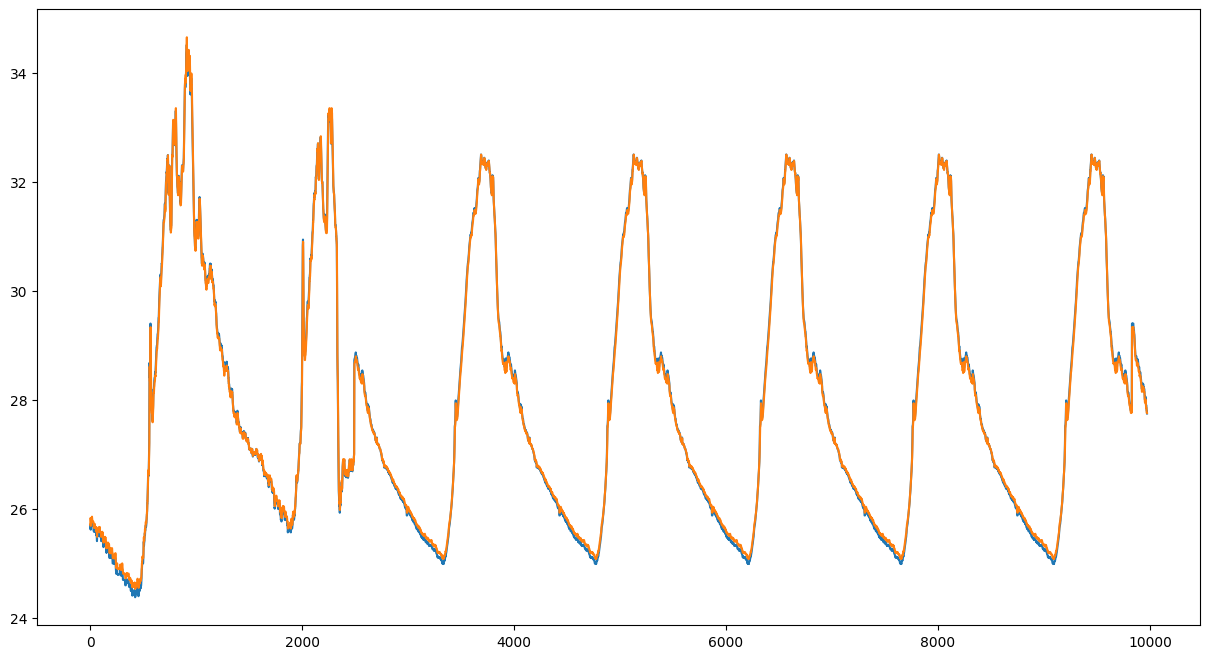

In [42]:
fig, ax = plt.subplots()
ax.plot(scaler.inverse_transform(y_test))
ax.plot(scaler.inverse_transform(pred))
plt.show()

In [43]:
mae = mean_absolute_error(scaler.inverse_transform(y_test), scaler.inverse_transform(pred))
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test), scaler.inverse_transform(pred))
rmse = root_mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(pred))

print(f'''
mae\t: {mae}
mape\t: {mape}
rmse\t: {rmse}
''')


mae	: 0.05597402312721396
mape	: 0.0020399615330234694
rmse	: 0.07200458395759797



In [57]:
df_old = df.tail(60 * 24)
df_old

,airTemperature
datetime,
2024-11-23 12:28:00+00:00,26.76
2024-11-23 12:29:00+00:00,26.77
2024-11-23 12:30:00+00:00,26.77
2024-11-23 12:31:00+00:00,26.78
2024-11-23 12:32:00+00:00,26.78
...,...
2024-11-24 12:23:00+00:00,27.81
2024-11-24 12:24:00+00:00,27.80
2024-11-24 12:25:00+00:00,27.80


In [58]:
old_data = scaler.transform(df_old)
old_data, _  = create_features(old_data)
old_data.shape

(1380, 60, 1)

In [59]:
new_pred = scaler.inverse_transform(model.predict(old_data))
new_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[ 26.545622],
       [ 26.522999],
       [ 26.498802],
       ...,
       [113.14826 ],
       [111.36507 ],
       [109.79773 ]], dtype=float32)

In [60]:
startdate = df_old.index[-1] + pd.Timedelta(minutes=1)
datetime = pd.date_range(start=startdate, freq='1min', periods=new_pred.shape[0])
df_pred = pd.DataFrame({'prediction': new_pred.reshape(-1)}, index=datetime)
df_pred

,prediction
2024-11-24 12:28:00+00:00,26.545622
2024-11-24 12:29:00+00:00,26.522999
2024-11-24 12:30:00+00:00,26.498802
2024-11-24 12:31:00+00:00,26.468203
2024-11-24 12:32:00+00:00,26.430153
...,...
2024-11-25 11:23:00+00:00,117.056732
2024-11-25 11:24:00+00:00,115.055817
2024-11-25 11:25:00+00:00,113.148262
2024-11-25 11:26:00+00:00,111.365067


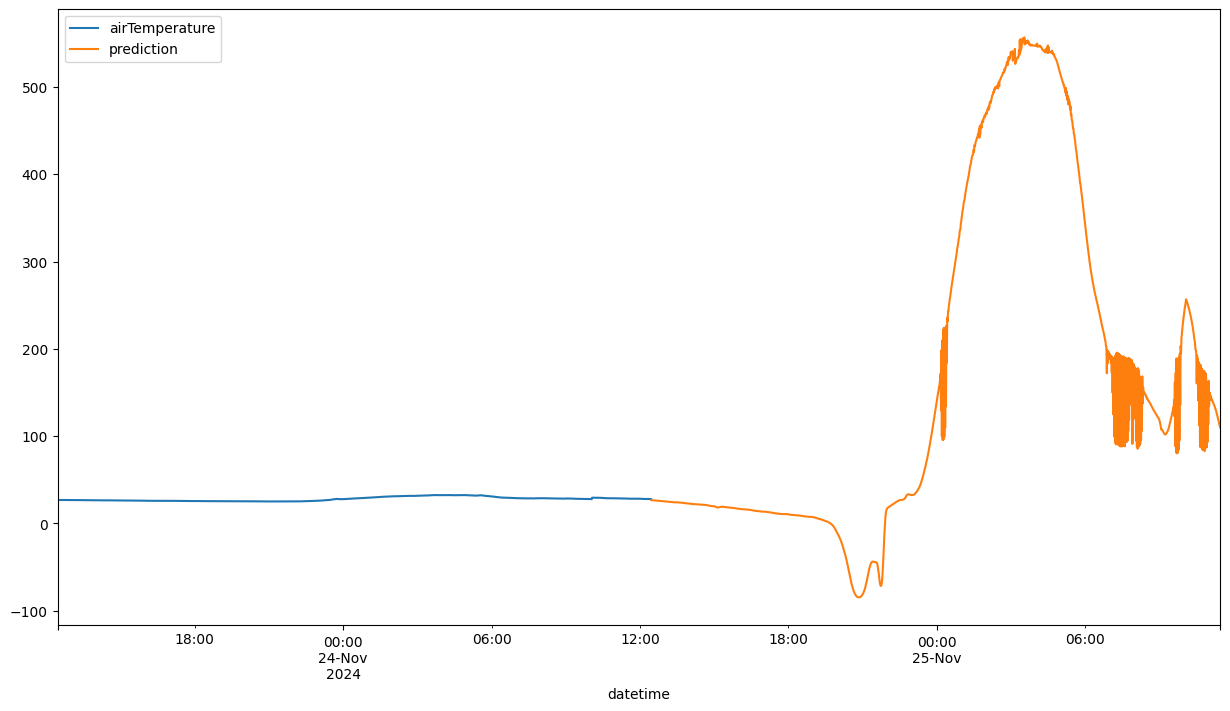

In [61]:
fig, ax = plt.subplots()
df_old.plot(ax=ax)
df_pred.plot(ax=ax)
plt.show()